In [374]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array
from hera_filters import dspec

from hera_cal import nucal, datacontainer, apply_cal, redcal, abscal
from jax import numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

from copy import deepcopy
%matplotlib notebook
from hera_cal import nucal, datacontainer, apply_cal, utils

In [375]:
MAX_BL_CUT = 100

In [376]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

In [377]:
nfreqs = 1500
nants = 20
npix = 500
freqs = np.linspace(50e6, 250e6, nfreqs)
sky = np.random.uniform(0, 10, size=(1, npix)) * (freqs[:, None] / 150e6) ** -0.75
l = np.linspace(-1, 1, npix)
beam = np.sinc(l[:, None] / np.sin(0.25 * 150e6 / freqs[None, :]))
s_hat = np.array([l])

antpos = linear_array(nants, sep=10)

bls = []
scale = 1
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            bls.append((antpos[aj] - antpos[ai]) * scale)
            
bls = np.array(bls)[:, 0][:, None]


dx = np.diff(l)[0]
u = (freqs * bls / 2.998e8)

top = np.argsort(sky[0])[30:]

fringe1 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] + dx / 2))
fringe2 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] - dx / 2))
fringe = 1./(-2j * np.pi * u[..., None]) * (fringe1 - fringe2) / dx
V_sky = np.sum(sky[None, :, :] * beam.T[None] * fringe, axis=-1)
V_sky_inc = np.sum(sky[None, :, top] * beam[top].T[None] * fringe[..., top], axis=-1)

autos = np.sum(sky[None, :, top] * beam[top].T[None], axis=-1)

In [378]:
# Generate Gains
tau = np.random.normal(2000e-9, 200e-9, size=(nants, 1))
ra = np.random.exponential(0.01, (nants, 1))
phi = np.random.uniform(0, 2 * np.pi, size=(nants, 1))
g_a = (1 + ra * np.exp(2j * np.pi * freqs * tau + 1j * phi))

<IPython.core.display.Javascript object>


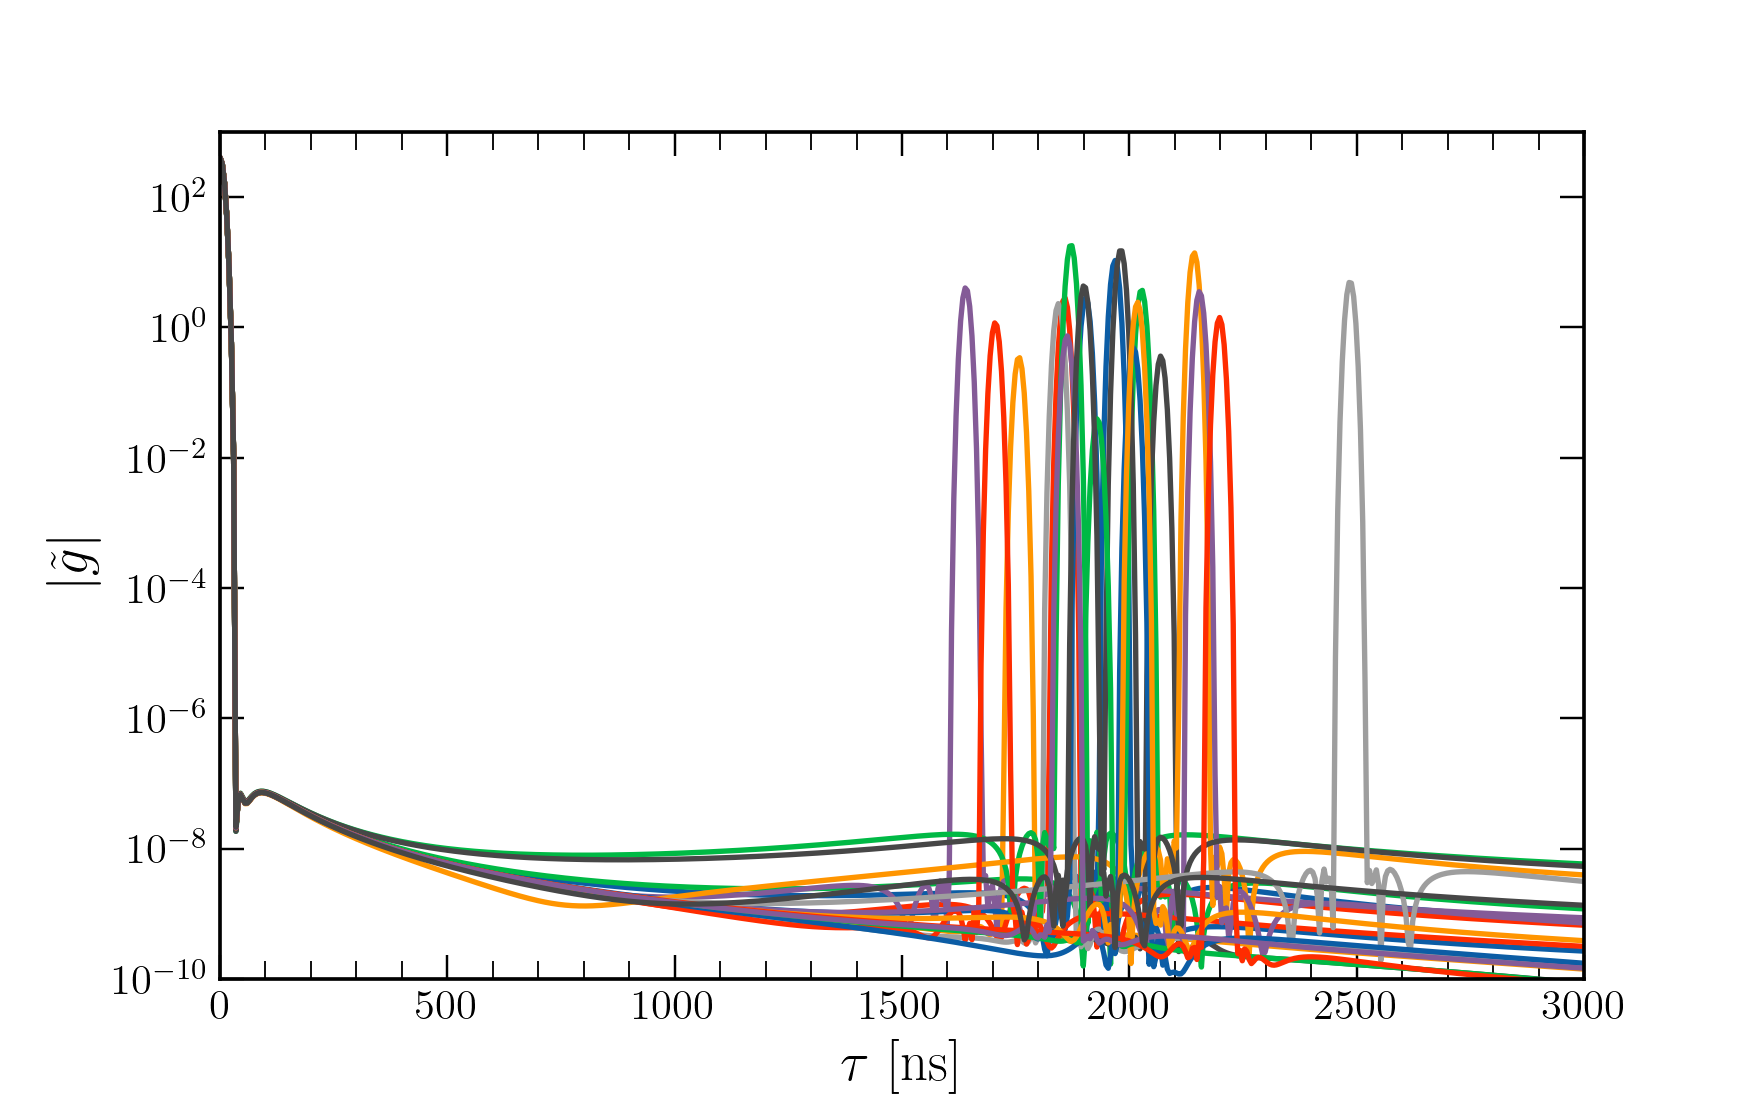

In [379]:
tau = uvtools.utils.fourier_freqs(freqs) * 1e9
plt.figure()
for i in range(nants):
    plt.semilogy(tau, delay_spectra(g_a[i]))
    
plt.xlim([0, 3000])
plt.ylim([1e-10, 1e3])
plt.xlabel(r'$\tau \ [\rm ns]$')
plt.ylabel(r'$|\tilde{g}|$')
plt.show()

In [381]:
# Store data
vis_dict = {}
model_dict = {}
true_dict = {}
ci = 0
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            #g1 = ant_amp[ai] * np.exp(1j * ant_phase[ai])
            #g2 = ant_amp[aj] * np.exp(1j * ant_phase[aj])
            g1 = g_a[ai]
            g2 = g_a[aj]
            noise = np.random.normal(0, 1e-4, size=(1, nfreqs)) + 1j * np.random.normal(0, 1e-4, size=(1, nfreqs))
            vis_dict[(ai, aj, 'nn')] = (V_sky[ci] * g1 * g2.conj())[None, :] + noise
            true_dict[(ai, aj, 'nn')] = V_sky[ci][None, :] 
            model_dict[(ai, aj, 'nn')] = V_sky_inc[ci][None, :]
            ci += 1
            
        if aj == ai:
            vis_dict[(ai, aj, 'nn')] = g_a[ai] * g_a[aj] * autos
        
        
            
            
data = datacontainer.DataContainer(vis_dict)
data.freqs = freqs
data.antpos = antpos
data.times_by_bl = {k[:2]: np.array([0]) for k in data}

model = datacontainer.DataContainer(model_dict)
model.freqs = freqs
model.antpos = antpos

## Redundantly Calibrate


In [382]:
reds = redcal.get_reds(antpos)
meta, sol = redcal.redundantly_calibrate(data, reds)

In [446]:
redcal.redundantly_calibrate??

<IPython.core.display.Javascript object>


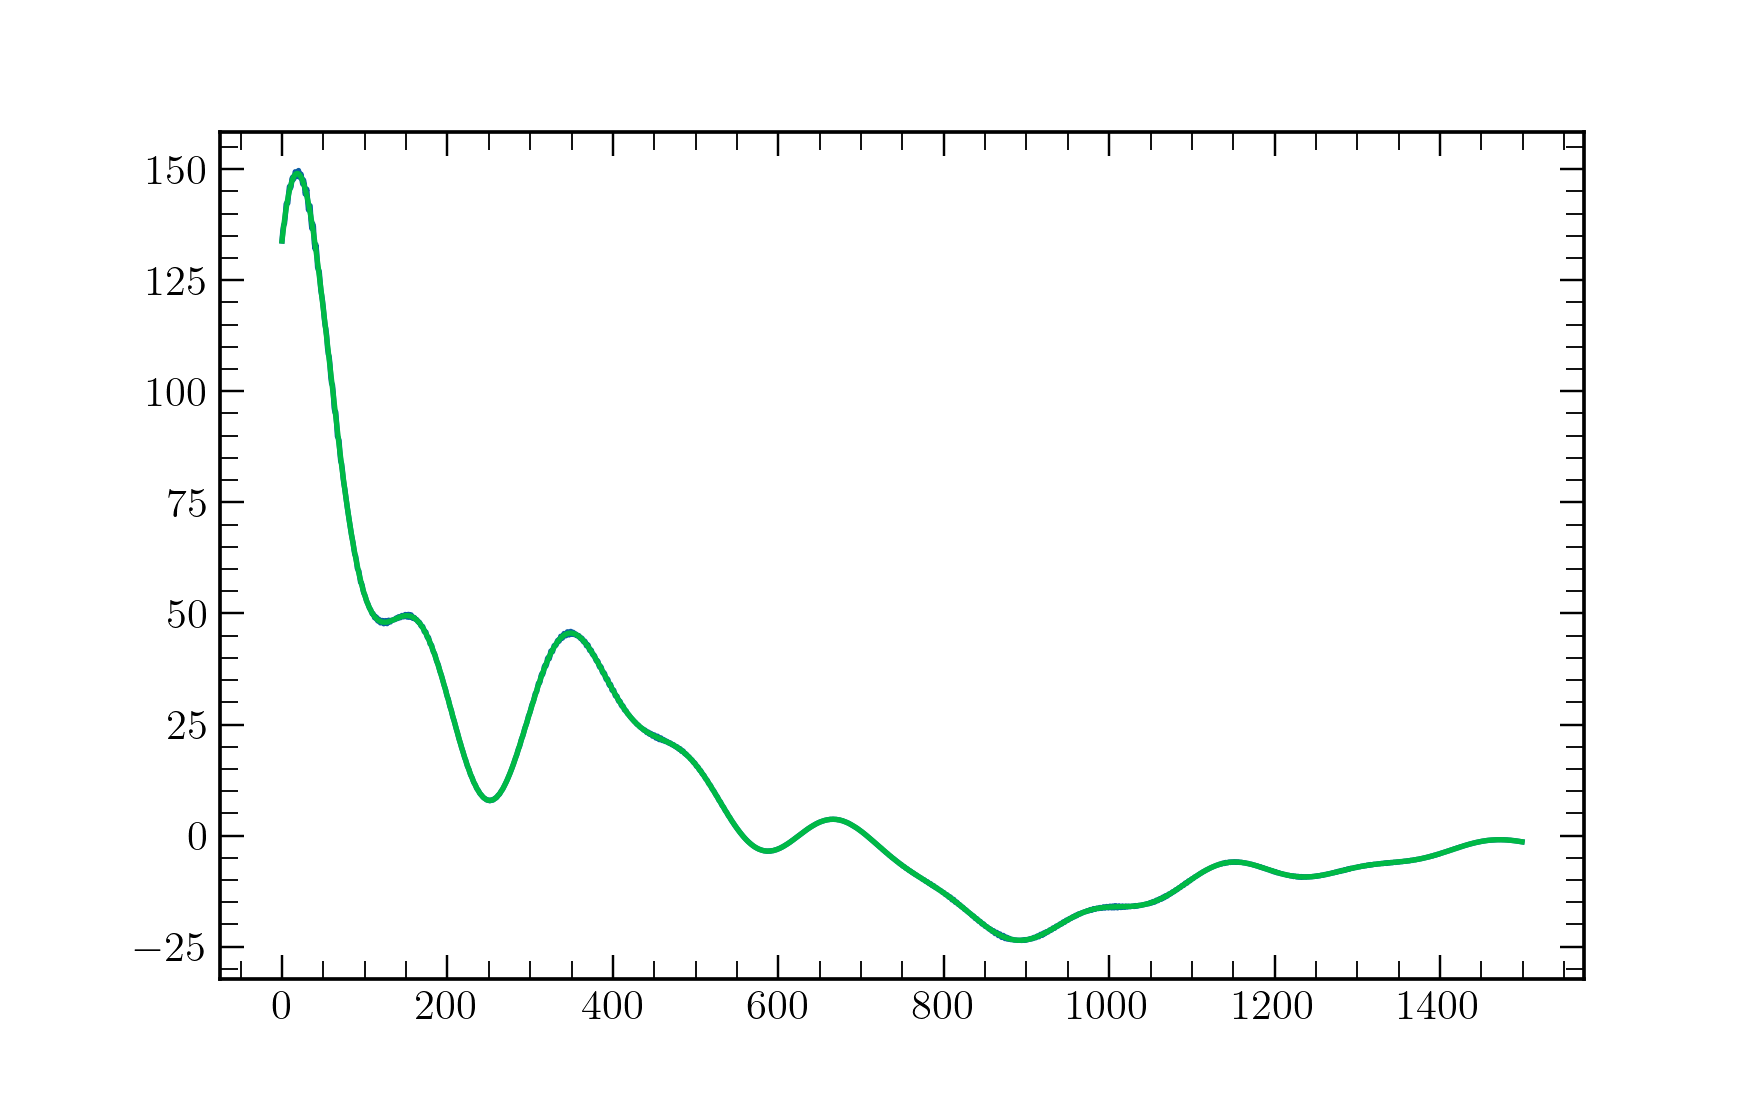

In [383]:
plt.figure()
plt.plot(sol[(0, 1, 'nn')].T)
plt.plot(true_dict[(0, 1, 'nn')].T)
plt.show()

<IPython.core.display.Javascript object>


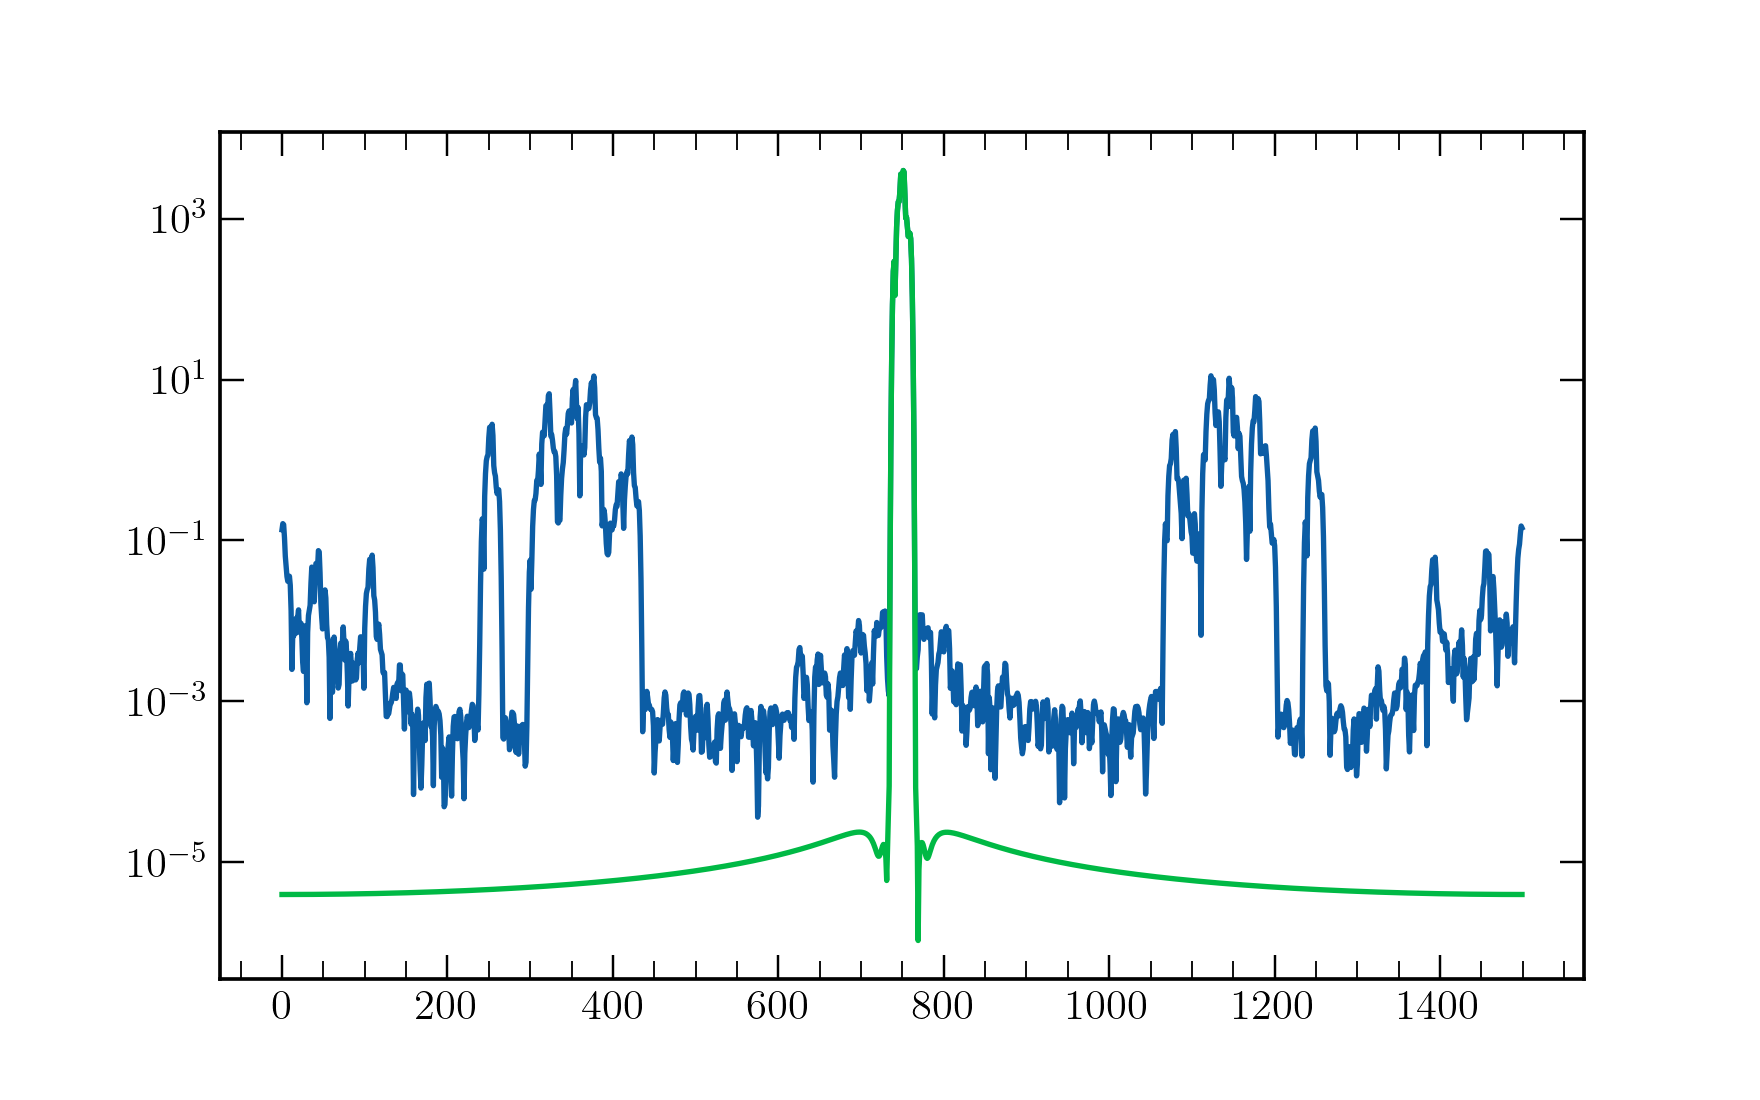

In [384]:
plt.figure()
plt.semilogy(delay_spectra(sol[(0, 1, 'nn')][0]))
plt.semilogy(delay_spectra(true_dict[(0, 1, 'nn')][0]))
plt.show()

## Absolute Calibration w/ Incomplete Sky Model

In [385]:
gain_ants = [(i, "Jnn") for i in range(nants)]
model_bls = [k for k in sol.vis if np.linalg.norm(antpos[k[0]] - antpos[k[1]]) < MAX_BL_CUT]
data_bls = deepcopy(model_bls)

X = dspec.dpss_operator(freqs, [0], [1 / 10e6], eigenval_cutoff=[1e-12])[0].real

In [386]:
%%time
sol_copy = deepcopy(sol)
sol_smooth = deepcopy(sol)
amp_gains = abscal.abs_amp_logcal(model, sol, return_gains=True, gain_ants=gain_ants, verbose=False)
meta, phs_gains = abscal.complex_phase_abscal(sol, model, reds, model_bls, data_bls)
degen_gains = {k: amp_gains[k] * phs_gains[k] for k in amp_gains}

sol_copy.remove_degen(degen_gains)
smooth_gains = {k: (X @ (X.T @ sol_copy.gains[k].T)).T for k in sol_copy.gains}

sol_smooth = deepcopy(data)
apply_cal.calibrate_in_place(sol_smooth, smooth_gains)


CPU times: user 231 ms, sys: 22 ms, total: 253 ms
Wall time: 244 ms


<IPython.core.display.Javascript object>


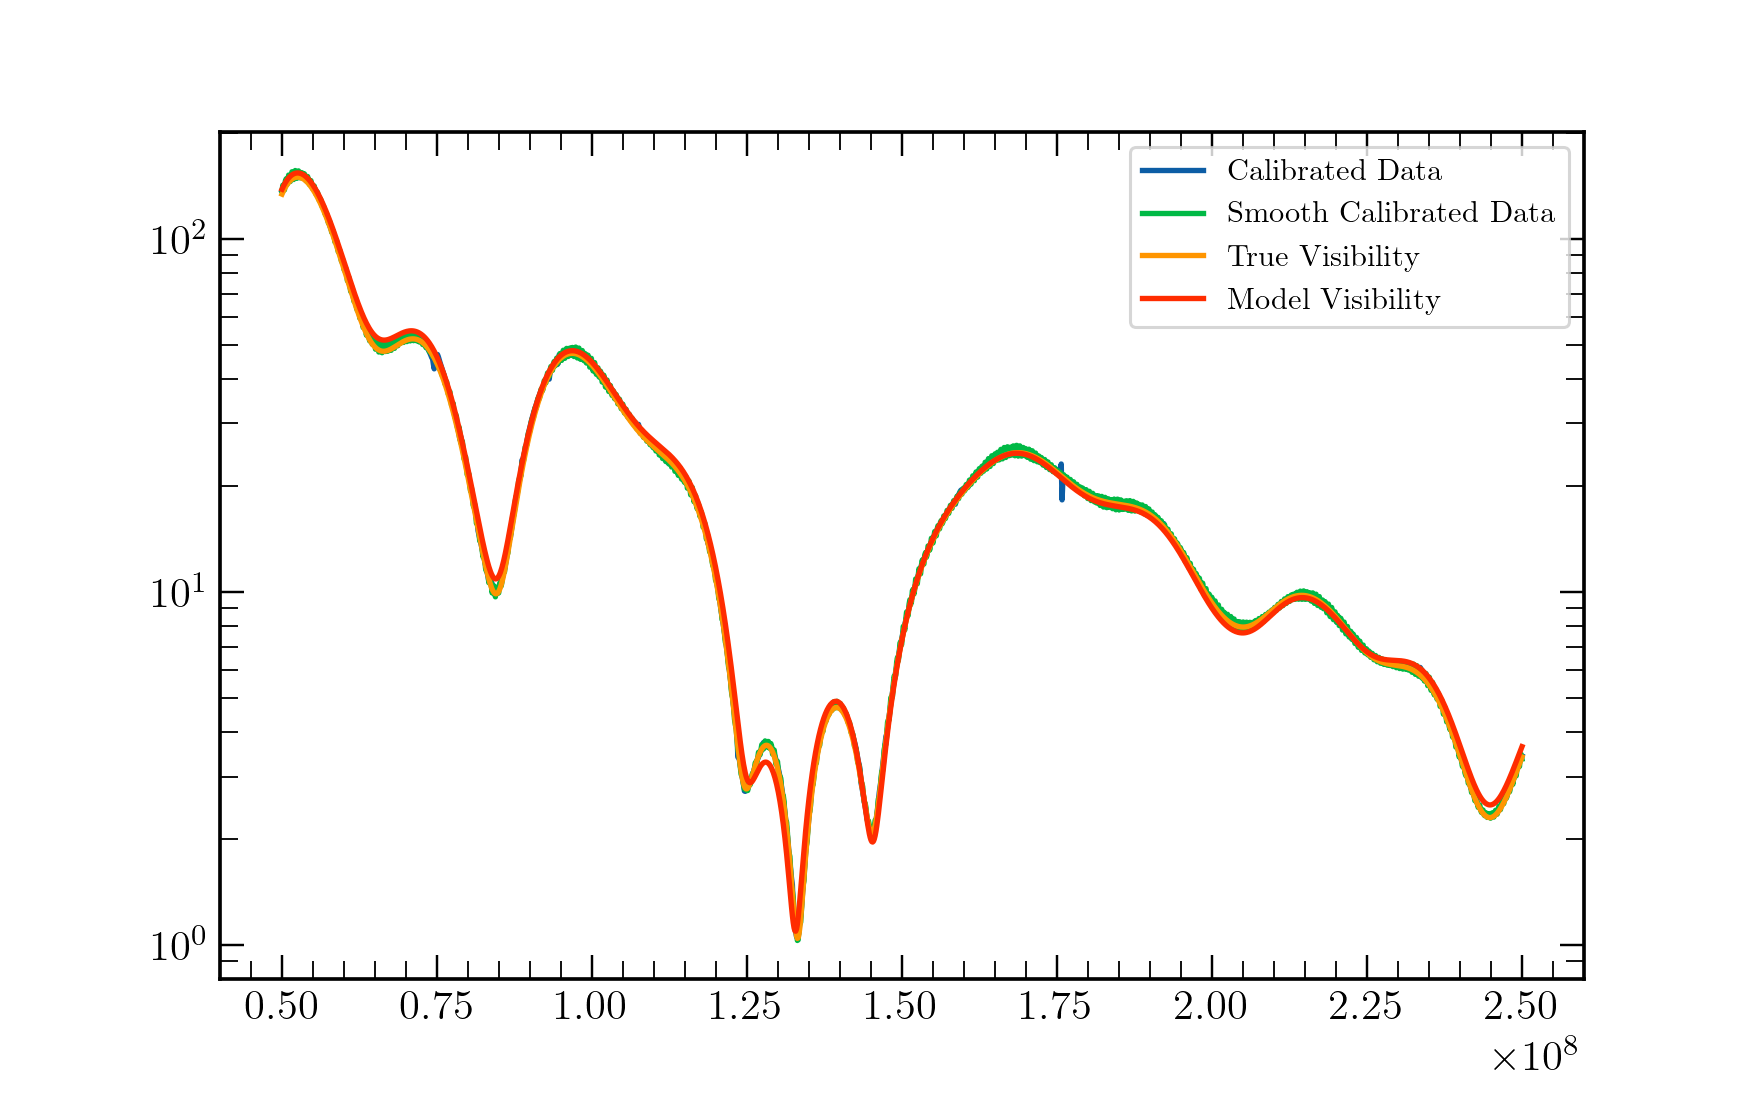

In [387]:
ant1, ant2 = 0, 1
ant_key = (ant1, ant2, 'nn')

plt.figure()
plt.plot(freqs, np.abs(sol_copy[ant_key]).T, label='Calibrated Data')
plt.plot(freqs, np.abs(sol_smooth[ant_key]).T, label='Smooth Calibrated Data')
plt.plot(freqs, np.abs(true_dict[ant_key]).T, label='True Visibility')
plt.plot(freqs, np.abs(model[ant_key]).T, label='Model Visibility')
#plt.plot(freqs, np.abs(sol[ant_key]).T, ls='-.', label='Calibrated Data')
plt.yscale('log')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


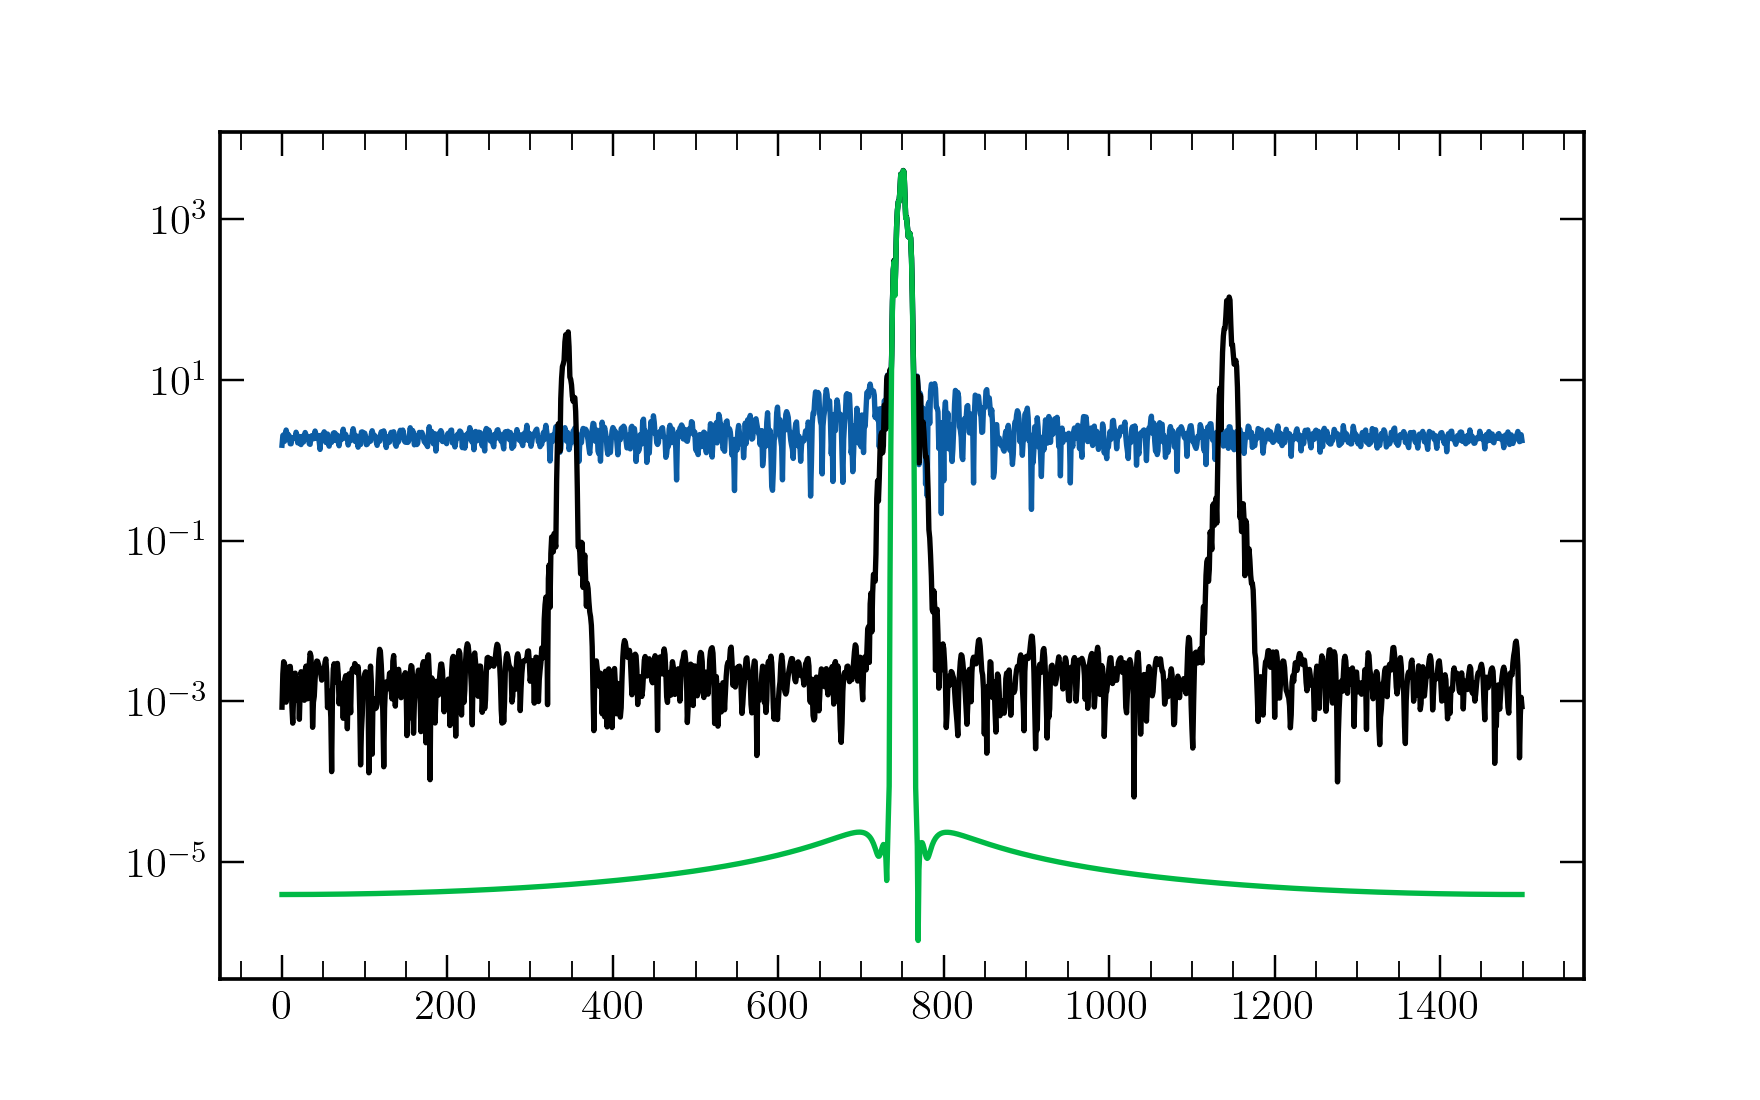

In [388]:
plt.figure()
plt.semilogy(delay_spectra(sol_copy[0, 1, 'nn'][0]))
plt.semilogy(delay_spectra(sol_smooth[0, 1, 'nn'][0]), color='k')
plt.semilogy(delay_spectra(true_dict[0, 1, 'nn'][0]))
plt.show()

## Fit Nucal Model to Calibrated Data

In [389]:
@jax.jit
def stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    def inner_function(args):
        """
        """
        g_temp, i, tau = args
        g_old = jnp.copy(g_temp)
        zg = g_temp[:, None] * model_matrix
        zgw = g_temp[:, None] * model_matrix * wgts
        g_temp = jnp.sum(jnp.conj(data_matrix) * zgw, axis=(0)) / jnp.sum(jnp.conj(zgw) * zg, axis=(0))
        g_temp = g_temp * stepsize + g_old * (1 - stepsize)
        tau = jnp.sqrt(jnp.sum(jnp.abs(g_temp - g_old) ** 2))/ jnp.sqrt(jnp.sum(jnp.abs(g_temp)**2))
        return g_temp, i + 1, tau
    
    def conditional_function(args):
        """
        """
        _, i, tau = args
        return (tau > tol) & (i < maxiter)
    
    nants = data_matrix.shape[0]
    gains = jnp.ones(nants, dtype=complex)
    
    return jax.lax.while_loop(conditional_function, inner_function, (gains, 0, 1))

def run_stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    gains = []
    niter = []
    for i in range(data_matrix.shape[-1]):
        g, i, tau = stefcal(data_matrix[..., i], model_matrix[..., i], wgts[..., i], tol=tol, maxiter=maxiter, stepsize=stepsize)
        gains.append(g)
        niter.append(i)
        
    return np.array(gains).T, np.array(niter).T

In [390]:
wgts = {k: np.ones_like(sol_smooth[k]).real for k in sol_smooth}
radial_reds = nucal.RadialRedundancy(antpos)
radial_reds.filter_radial_groups(max_bl_cut=MAX_BL_CUT)
spatial_filters = nucal.compute_spatial_filters(radial_reds, freqs)
spectral_filters = nucal.compute_spectral_filters(freqs, 30e-9)[0].real
nucal_model = nucal.fit_nucal_foreground_model(sol_smooth, wgts, radial_reds, spatial_filters, spectral_filters, tol=1e-9)

<IPython.core.display.Javascript object>


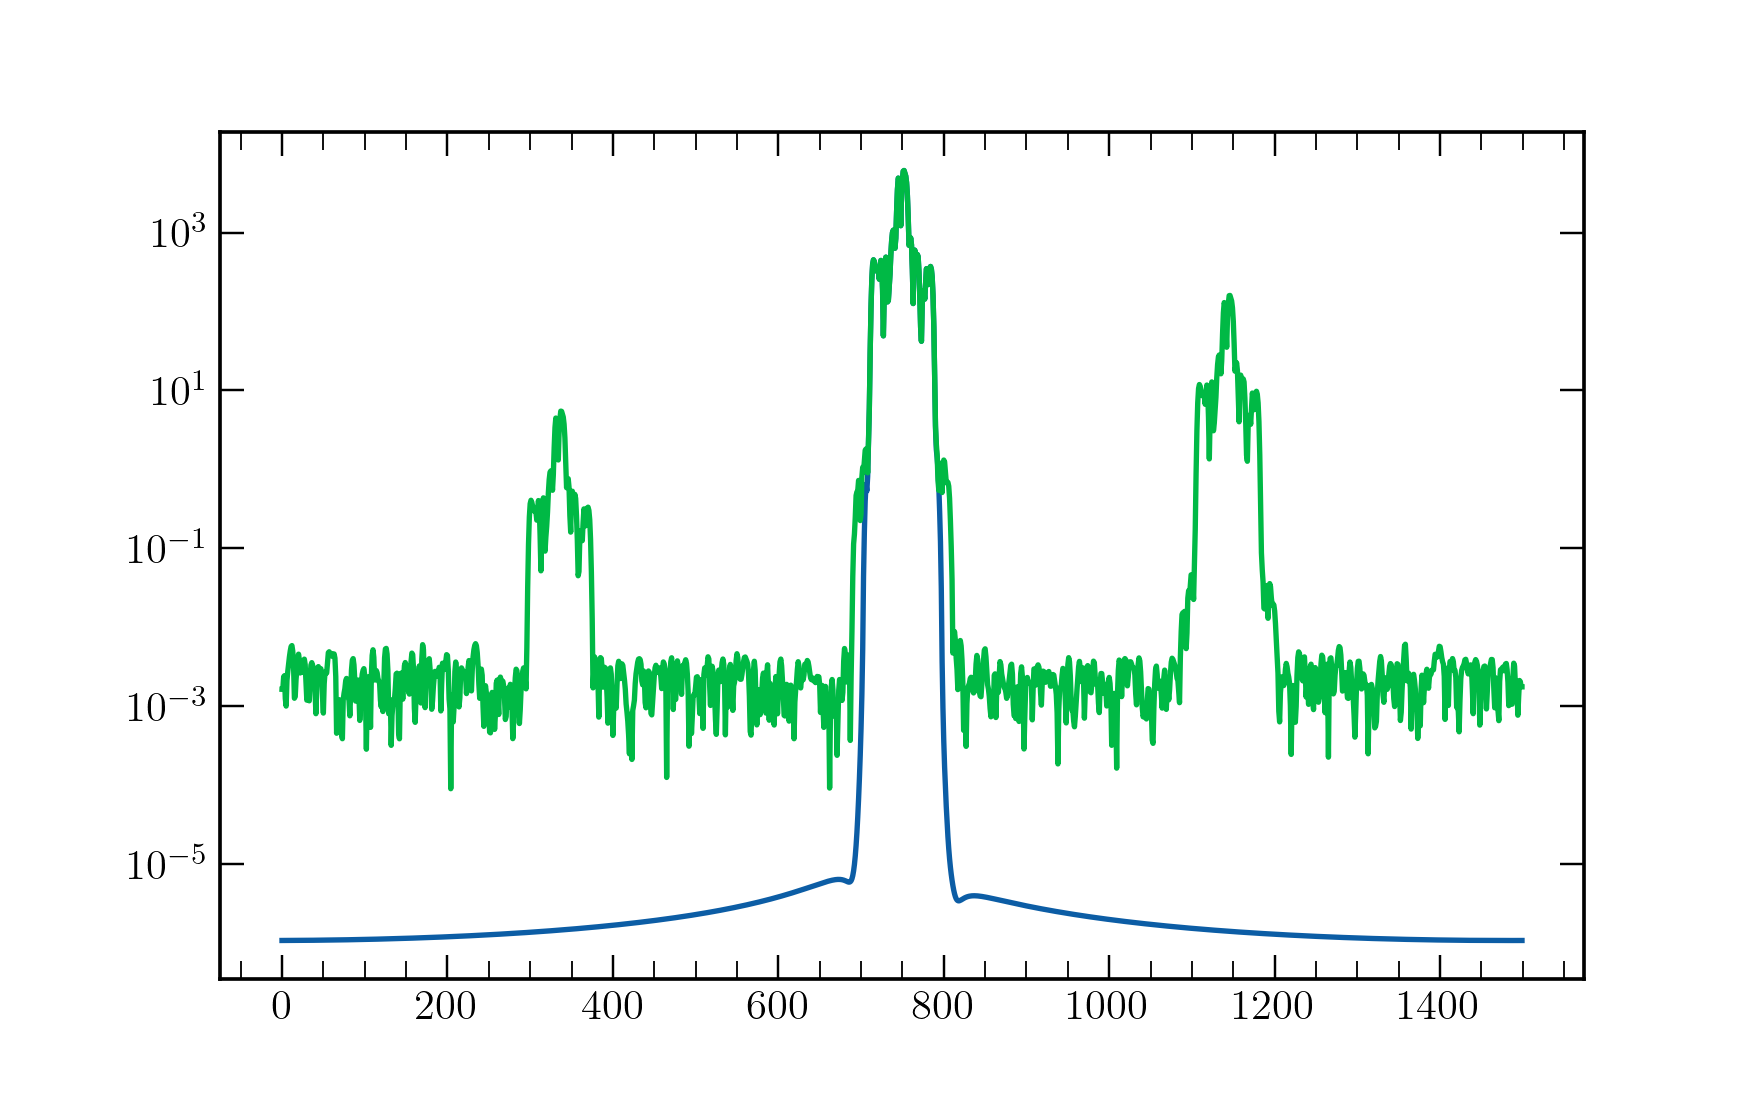

In [391]:
plt.figure()
plt.semilogy(delay_spectra(nucal_model[(0, 5, 'nn')][0]))
plt.semilogy(delay_spectra(sol_smooth[(0, 5, 'nn')][0]))

In [392]:
%%time
Nants = nants
fi = 0

data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
nucal_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
true_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)

nucal_model = datacontainer.DataContainer(nucal_model)
true_dict = datacontainer.DataContainer(true_dict)

wgts_array = np.zeros_like(nucal_model_matrix).real
for n in range(Nants):
    for m in range(Nants):
        if n != m:
            if np.linalg.norm(antpos[m] - antpos[n]) < MAX_BL_CUT:
                data_matrix[m, n] = data[(m, n, 'nn')]
                nucal_model_matrix[m, n] = nucal_model[radial_reds.get_redundant_group((m, n, 'nn'))[0]][0]
                true_model_matrix[m, n] = true_dict[(m, n, 'nn')]
                wgts_array[m, n] = 1
                

CPU times: user 173 ms, sys: 14.1 ms, total: 187 ms
Wall time: 189 ms


<IPython.core.display.Javascript object>


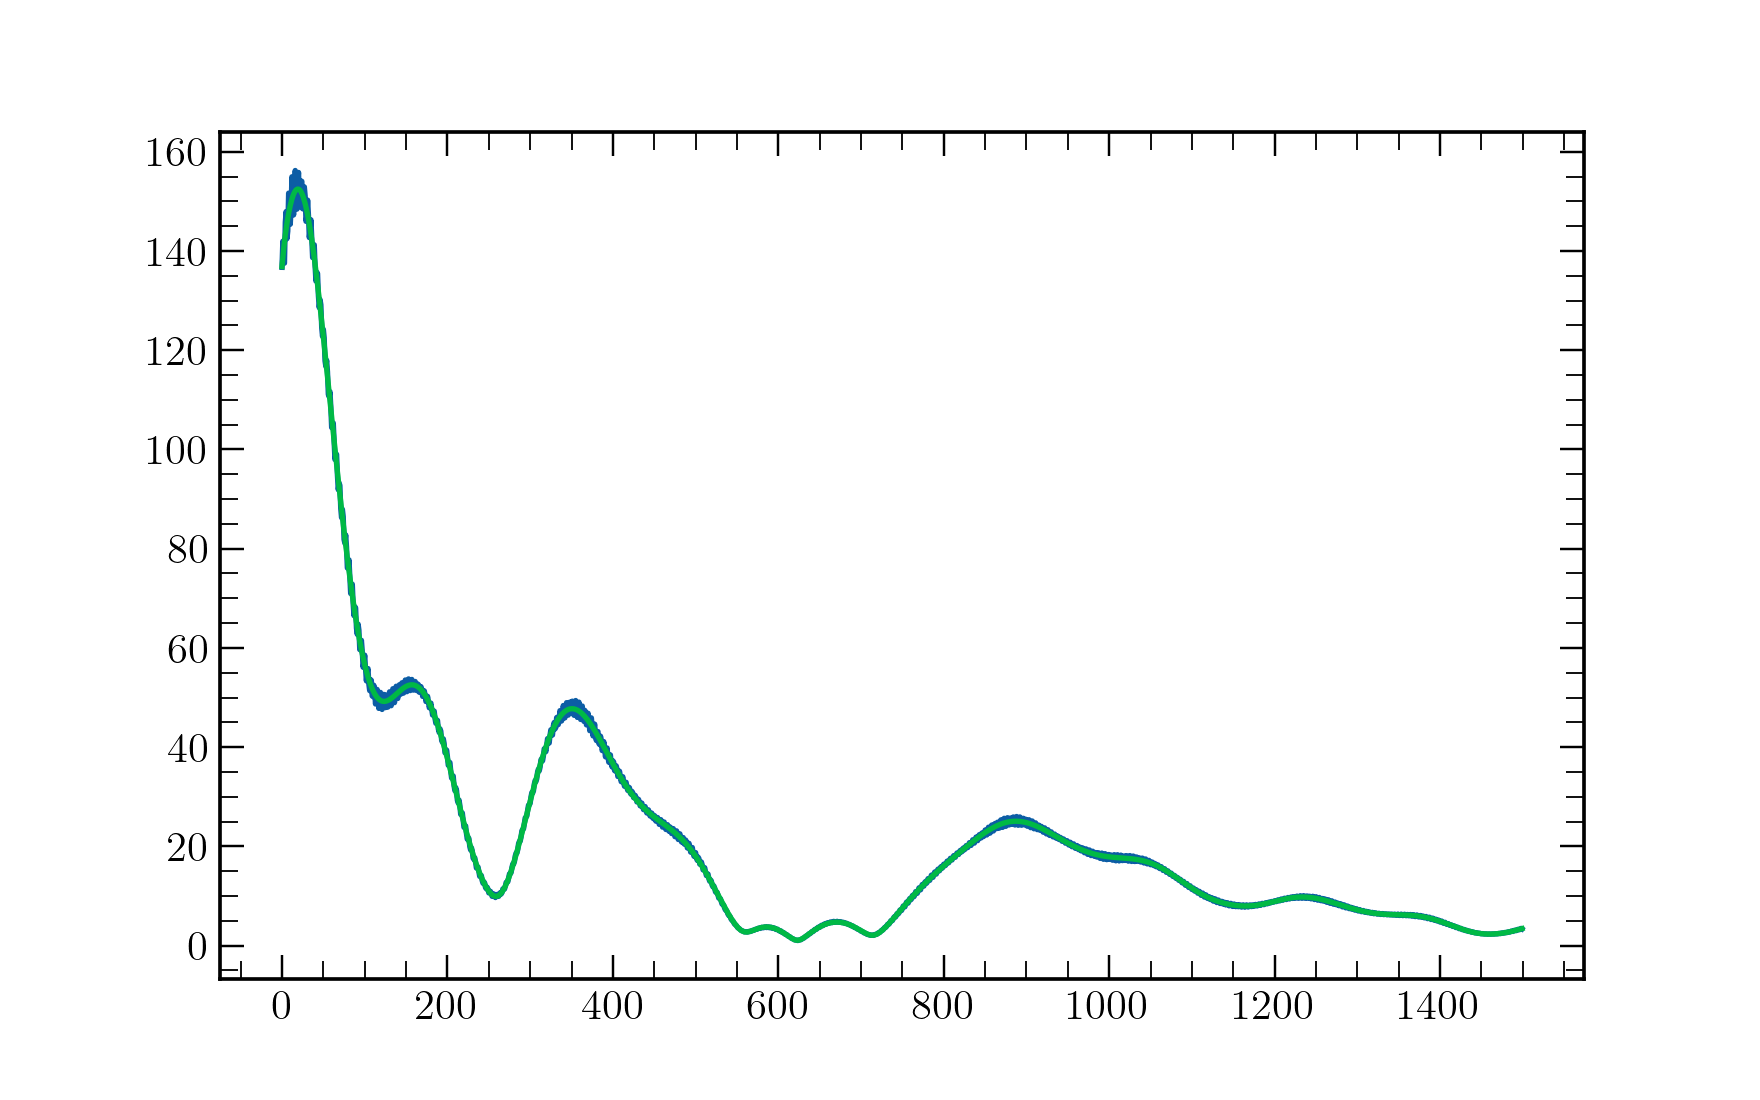

In [393]:
plt.figure()
plt.plot(np.abs(sol_smooth[(0, 1, 'nn')][0]))
plt.plot(np.abs(nucal_model_matrix[0, 1]))
plt.show()

In [394]:
%%time
gstef_new, niter = run_stefcal(data_matrix, nucal_model_matrix, wgts_array, maxiter=1000, tol=1e-10, stepsize=0.5)

CPU times: user 812 ms, sys: 428 ms, total: 1.24 s
Wall time: 1.36 s


In [395]:
Gfn = gstef_new[:, None, :] * gstef_new[None, ...].conj()
cal_fn = data_matrix / Gfn

<IPython.core.display.Javascript object>


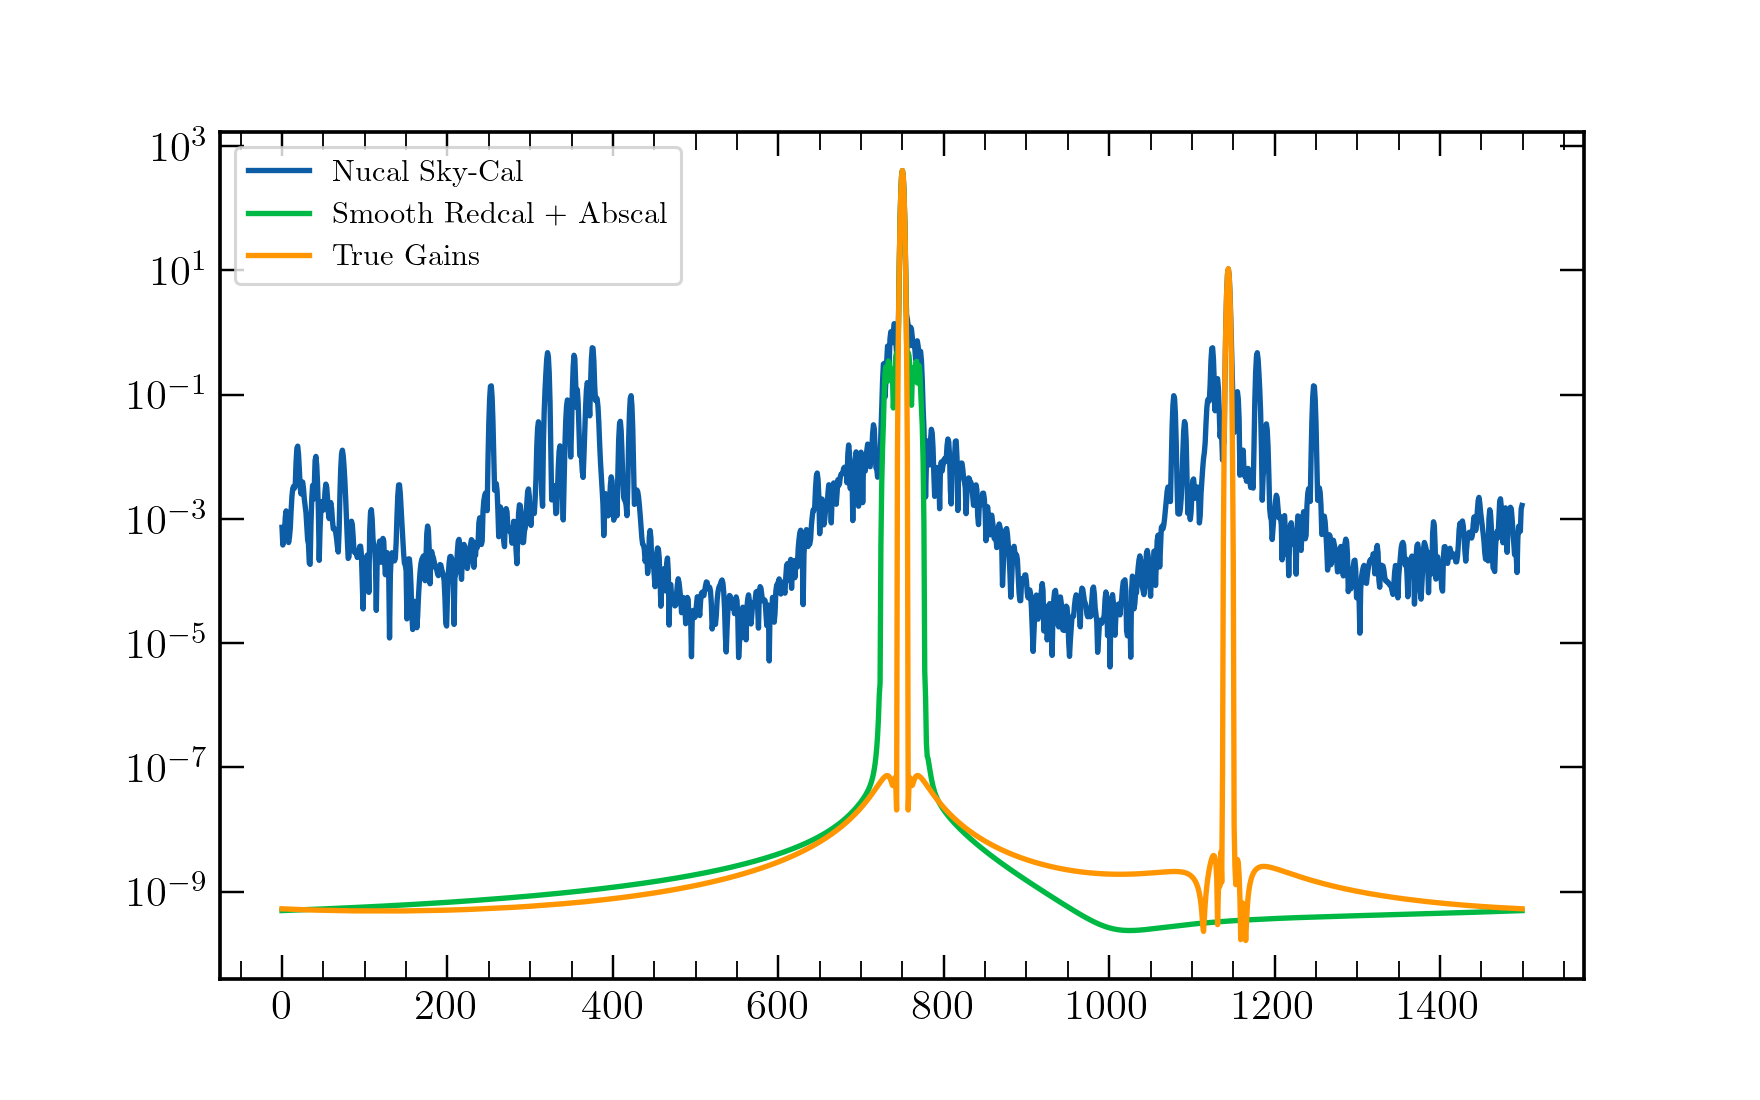

In [396]:
plt.figure()
plt.semilogy(delay_spectra(gstef_new[0]), label='Nucal Sky-Cal')
plt.semilogy(delay_spectra(smooth_gains[(0, 'Jnn')][0]), label='Smooth Redcal + Abscal')
plt.semilogy(delay_spectra(g_a[0]), label='True Gains')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


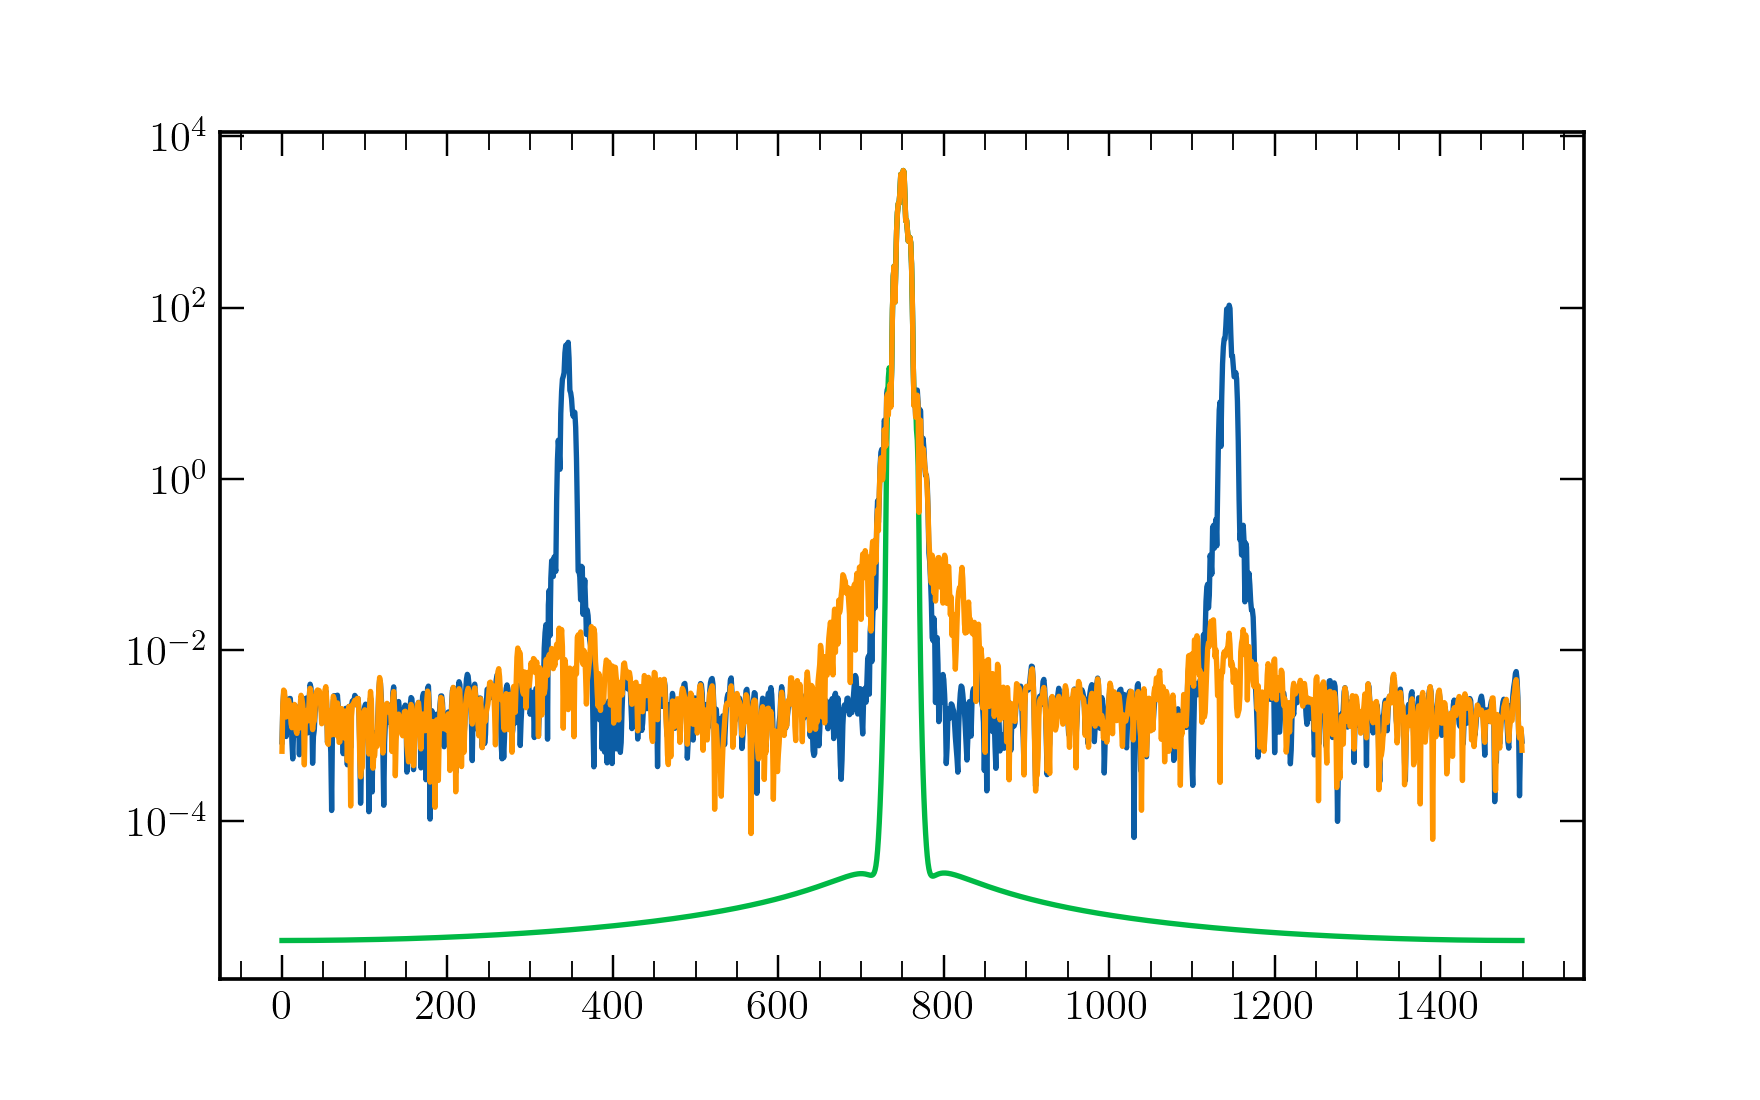

In [397]:
plt.figure()
plt.semilogy(delay_spectra(sol_smooth[(0, 1, 'nn')][0]))
plt.semilogy(delay_spectra(nucal_model_matrix[0, 1]))
plt.semilogy(delay_spectra(cal_fn[0, 1]))
plt.show()

## Self-Cal Iterate

In [440]:
from scipy import linalg
from hera_filters import dspec
import hashlib
import tqdm

def fit_nucal_foreground_model(data, data_wgts, radial_reds, spatial_filters, spectral_filters=None, tol=1e-15,
                               share_fg_model=False, return_model_comps=False, solver="lu_solve", cache=None):
    """
    """        
    # Create empty dictionary for model components
    model_comps = {}

    # Loop over radial groups
    for group in radial_reds:
        # Get the data and design matrix for this group
        design_matrix = np.array([spatial_filters[bl] for bl in group])
        wgts_here = np.array([data_wgts[bl] for bl in group])
        data_here = np.array([data[bl] for bl in group])
                
        # Get number of fit parameters
        if spectral_filters is not None:
            ndim = spectral_filters.shape[1] * design_matrix.shape[-1]

        # Compute the XTX
        if share_fg_model:
            # Compute the XTX and XTWy
            if spectral_filters is None:
                XTX = jnp.einsum("afm,atf,afn->mn", design_matrix, wgts_here, design_matrix)
                Xy = jnp.einsum("afm,atf->m", design_matrix, data_here * wgts_here)

                # Solve for model components
                beta = _linear_fit(XTX, Xy, solver=solver, tol=tol, cache=cache, rdgrp=group)
            else:
                XTX = jnp.einsum("fm,afn,atf,fk,afj->mnkj", 
                    spectral_filters, design_matrix, wgts_here, spectral_filters, design_matrix
                ).reshape(ndim, ndim)
                Xy = jnp.einsum("fm,afn,atf->mn", spectral_filters, design_matrix, data_here * wgts_here).reshape(ndim)

                # Solve for the foreground model components
                beta = _linear_fit(XTX, Xy, tol=tol, solver=solver, cache=cache, rdgrp=group)
                beta = beta.reshape(spectral_filters.shape[-1], design_matrix.shape[-1])

            # Expand the model components to have time index
            beta = np.expand_dims(beta, axis=0)

        else:
            # Create empty list to hold the model components for each time
            beta = []

            # Loop over time
            for i in range(data_here.shape[1]):
                # Compute the XTX and XTWy
                if spectral_filters is None:
                    XTX = jnp.einsum("afm,af,afn->mn", design_matrix, wgts_here[:, i], design_matrix)
                    Xy = jnp.einsum("afm,af->m", design_matrix, data_here[:, i] * wgts_here[:, i])

                    # Solve for model components
                    beta.append(_linear_fit(XTX, Xy, solver=solver, tol=tol, cache=cache, rdgrp=group))

                else:
                    XTX = jnp.einsum("fm,afn,af,fk,afj->mnkj", 
                        spectral_filters, design_matrix, wgts_here[:, i], spectral_filters, design_matrix
                    ).reshape(ndim, ndim)
                    Xy = jnp.einsum("fm,afn,af->mn", spectral_filters, design_matrix, data_here[:, i] * wgts_here[:, i]).reshape(ndim)
                    
                    # Solve for the foreground model components
                    _beta = _linear_fit(XTX, Xy, tol=tol, solver=solver, cache=cache, rdgrp=group)
                    beta.append(_beta.reshape(spectral_filters.shape[-1], design_matrix.shape[-1]))
            
            # Pack solution into an array
            beta = np.array(beta)

        # Store the model components
        model_comps[group[0]] = beta
                        
    if return_model_comps:
        return model_comps
    else:
        return nucal.evaluate_foreground_model(radial_reds, model_comps, spatial_filters=spatial_filters, spectral_filters=spectral_filters)
    
def _linear_fit(XTX, Xy, solver='lu_solve', tol=1e-15, cache=None, rdgrp=None):
    """
    """
    # Assert that the method is valid
    assert solver in ['lu_solve', 'solve', 'pinv', 'lstsq'], "method must be one of {}".format(['lu_solve', 'solve', 'pinv', 'lstsq'])

    # Assert that the regularization tolerance is non-negative
    assert tol >= 0.0, "tol must be non-negative."

    # Add regularization tolerance to the diagonal of XTX
    # If XTX is a jax array, use the jax array indexing syntax
    if (solver == "lu_solve" or solver == "solve") and isinstance(XTX, jnp.ndarray):
        XTX = XTX.at[np.diag_indices_from(XTX)].add(tol)
    elif (solver == "lu_solve" or solver == "solve"):
        XTX[np.diag_indices_from(XTX)] += tol
        
    if cache is not None:
        #hashkey = hashlib.sha1(np.round(np.ascontiguousarray(XTX), 10))
        hashkey = hashlib.sha1(solver.encode('utf-8'))
        if rdgrp is not None:
            hashkey.update(str(rdgrp).encode('utf-8'))
            
        key = hashkey.hexdigest()

    if solver == 'lu_solve':
        # Factor XTX using scipy.linalg.lu_factor
        if cache is not None and key in cache:
            L = cache[key]
            
        else:
            L = linalg.lu_factor(XTX)   
            if cache is not None:
                cache[key] = L

        # Solve the linear system of equations using scipy.linalg.lu_solve
        beta = linalg.lu_solve(L, Xy)
        
    elif solver == 'solve':
        # Solve the linear system of equations using np.linalg.solve
        beta = np.linalg.solve(XTX, Xy)

    elif solver == 'pinv':
        if cache is not None and key in cache:
            XTXinv = cache[key]
        else:
            if cache is not None:
                cache[key] = XTXinv
        
        # Compute the pseudo-inverse of XTX using np.linalg.pinv
        XTXinv = np.linalg.pinv(XTX, rcond=tol)

        # Compute the model parameters using the pseudo-inverse
        beta = np.dot(XTXinv, Xy)

    elif solver == 'lstsq':
        # Compute the model parameters using np.linalg.lstsq
        beta = np.linalg.lstsq(XTX, Xy, rcond=tol)[0]

    return beta

In [441]:
radial_reds = nucal.RadialRedundancy(antpos)
radial_reds.filter_radial_groups(max_bl_cut=MAX_BL_CUT)
spatial_filters = nucal.compute_spatial_filters(radial_reds, freqs)
spectral_filters = nucal.compute_spectral_filters(freqs, 20e-9)[0].real
wgts = {k: np.ones_like(data[k]).real for k in data}

In [447]:
%%time
gstef_new = np.ones_like(g_a)
g_final = np.ones_like(gstef_new)
dc = deepcopy(data)
cache = {}

nucal_model = fit_nucal_foreground_model(dc, wgts, radial_reds, spatial_filters, spectral_filters, tol=1e-9, cache=cache)

for i in tqdm.tqdm(range(30)):
    gains = {(i, "Jnn"): gstef_new[i][None, :] for i in range(gstef_new.shape[0])}
    apply_cal.calibrate_in_place(dc, gains)

    # Fit Nucal Model to Calibrated Data
    if i > 0:
        davg, _, _ = utils.red_average(dc)
        nucal_model = fit_nucal_foreground_model(davg, wgts, radial_reds, spatial_filters, spectral_filters, tol=1e-9, cache=cache)

    data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
    nucal_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
    nucal_model = datacontainer.DataContainer(nucal_model)
    wgts_array = np.zeros_like(nucal_model_matrix).real

    for n in range(Nants):
        for m in range(Nants):
            if n != m:
                if np.linalg.norm(antpos[m] - antpos[n]) < MAX_BL_CUT:
                    data_matrix[m, n] = dc[(m, n, 'nn')]
                    nucal_model_matrix[m, n] = nucal_model[radial_reds.get_redundant_group((m, n, 'nn'))[0]][0]
                    wgts_array[m, n] = 1
                    
    gstef_new, niters = run_stefcal(data_matrix, nucal_model_matrix, wgts_array, maxiter=1000, tol=1e-10, stepsize=0.666)
    g_final *= gstef_new

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.05s/it]

CPU times: user 1min 21s, sys: 13 s, total: 1min 34s
Wall time: 32.9 s


<IPython.core.display.Javascript object>


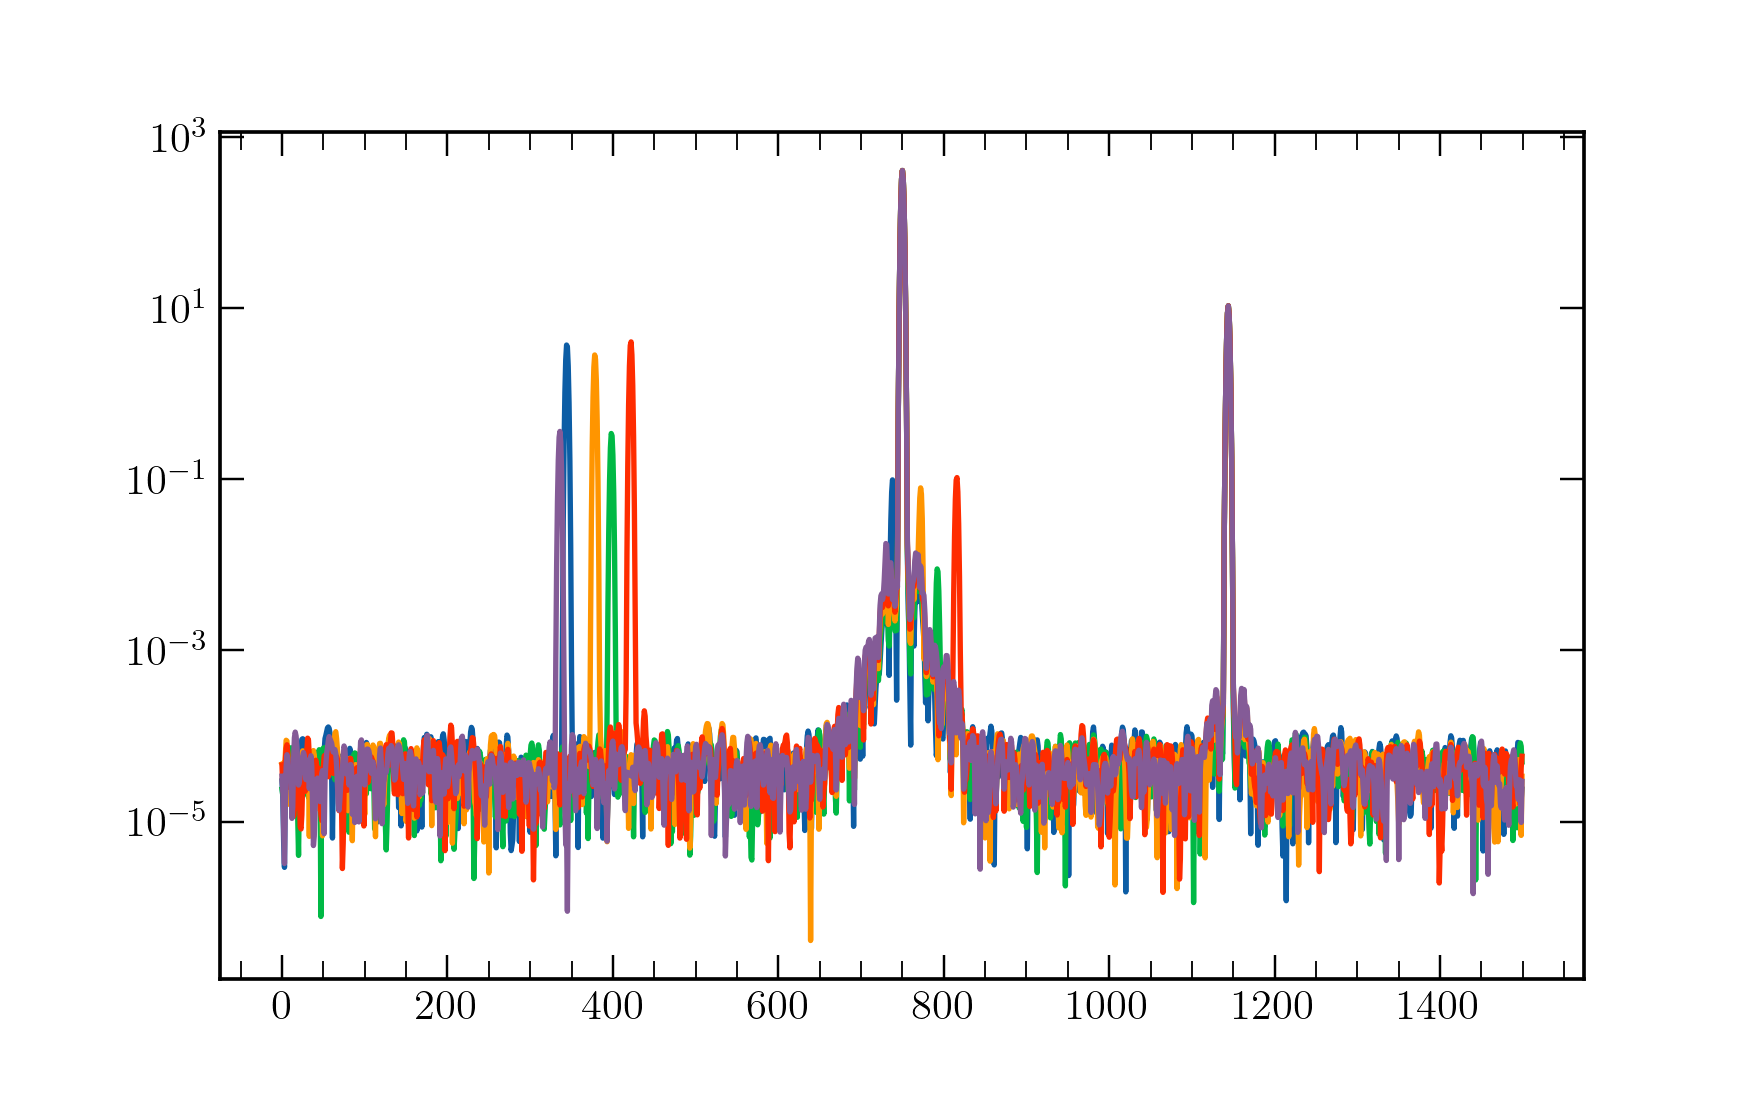

In [448]:
plt.figure()
for k in [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]:
    plt.semilogy(delay_spectra(g_final[k[0]] * g_final[k[1]].conj()))
    
plt.show()

In [449]:
for n in range(Nants):
    for m in range(Nants):
        if n != m:
            if np.linalg.norm(antpos[m] - antpos[n]) < 70:
                data_matrix[m, n] = data[(m, n, 'nn')]

Gfn = g_final[:, None, :] * g_final[None, ...].conj()
cal_fn = data_matrix / Gfn


<IPython.core.display.Javascript object>


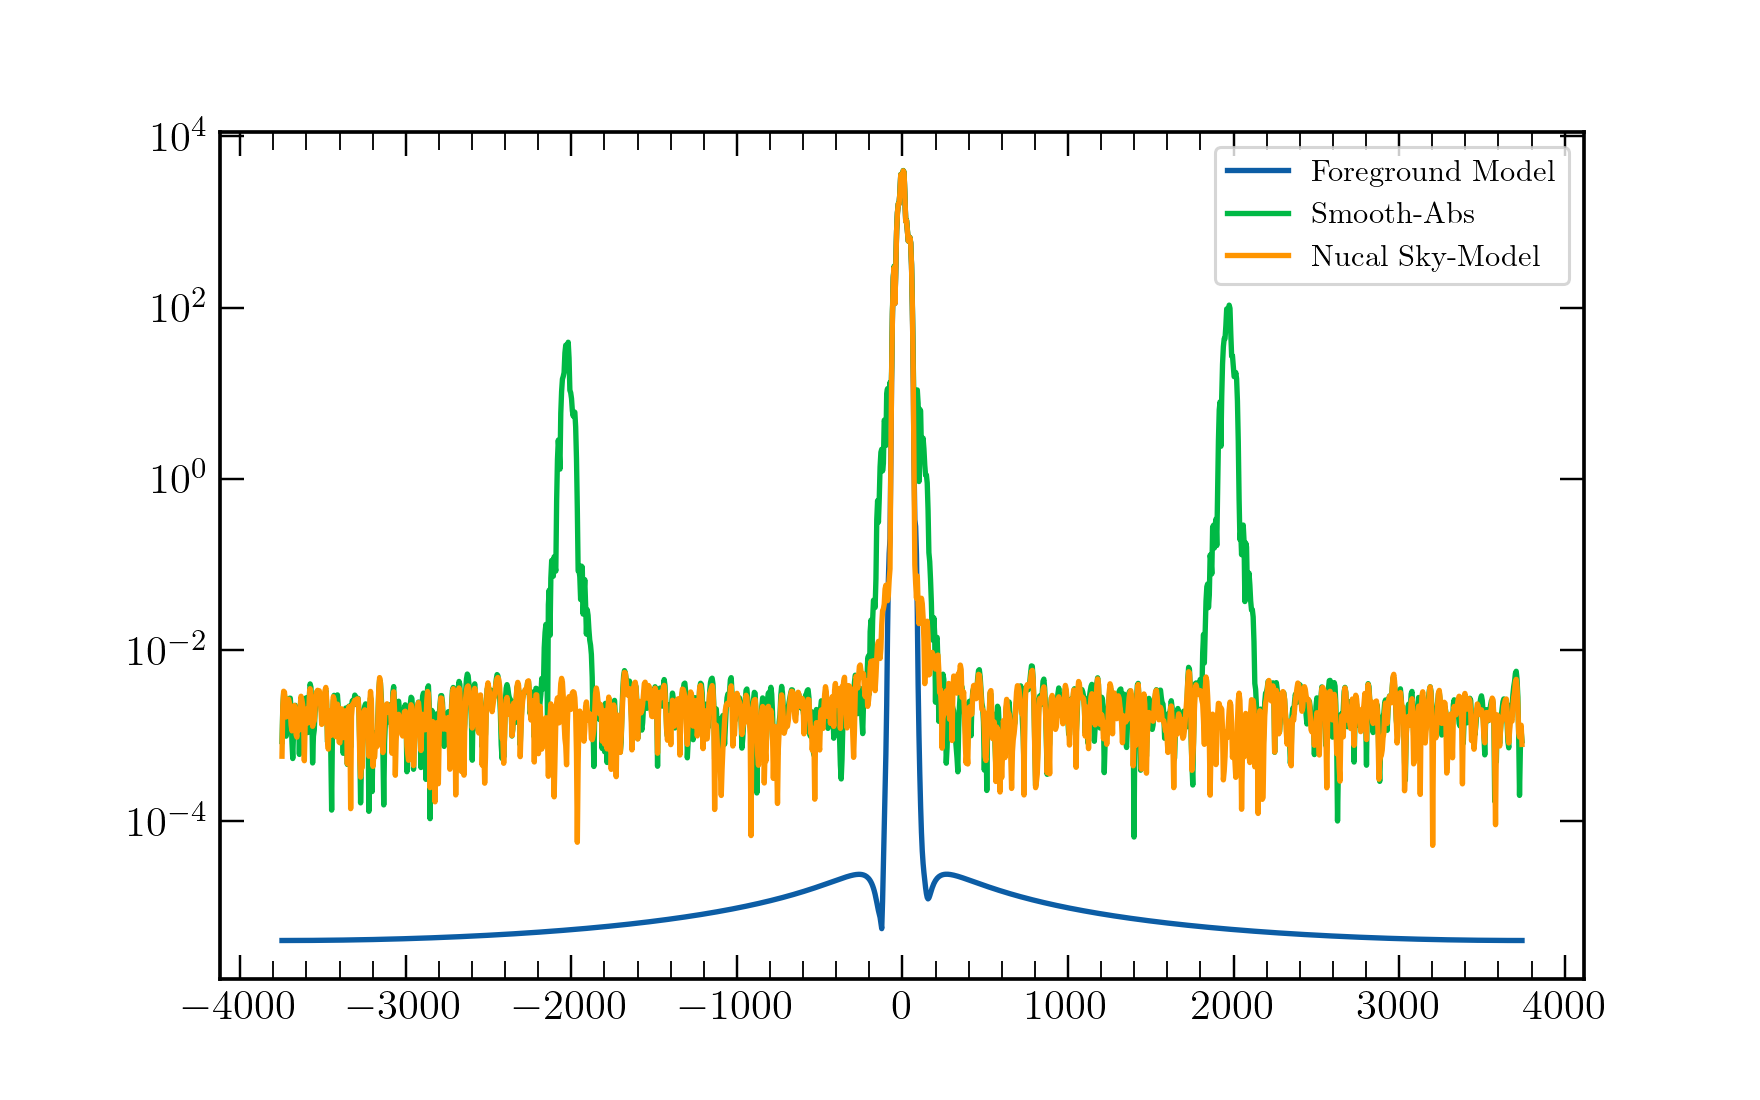

In [450]:
plt.figure()
ant1, ant2 = 0, 1
tau = uvtools.utils.fourier_freqs(freqs) * 1e9
plt.semilogy(tau, delay_spectra(nucal_model_matrix[ant1, ant2]), label='Foreground Model')
plt.semilogy(tau, delay_spectra(sol_smooth[(ant1, ant2, 'nn')][0]), label='Smooth-Abs')
plt.semilogy(tau, delay_spectra(cal_fn[ant1, ant2]), label='Nucal Sky-Model')
plt.legend()
plt.show()